# Lecture 9 - Natural Language Processing

## Load Data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                    attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                    attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                    class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                    class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head()

,news_headline,news_article,news_category
0,Elon Musk with $300 billion net worth becomes ...,World's richest person and Tesla CEO Elon Musk...,technology
1,"Reliance Jio declines AGR dues moratorium, bec...",Reliance Jio has reportedly said it won't opt ...,technology
2,Who is Indian-American Raja Chari who'll comma...,Indian-American astronaut Raja Chari will take...,technology
3,WhatsApp to no longer support Android phones w...,WhatsApp will no longer support Android phones...,technology
4,Mumbai Police shares meme on Facebook name cha...,After Facebook changed its company name to 'Me...,technology


In [4]:
news_df.news_category.value_counts()

technology    25
sports        25
world         25
Name: news_category, dtype: int64

## Text Preprocessing

### Noise Removal

In [5]:
noise_list = ["is", "a", "this", "..."]

def _remove_noise(input_text):
    words = input_text.split()
    noise_free_words = [word for word in words if word not in noise_list]
    noise_free_text = " ".join(noise_free_words)
    return noise_free_text

_remove_noise("this is a sample text")

'sample text'

In [6]:
# Lower Case
news_df['news_article'] = news_df['news_article']\
            .apply(lambda x: " ".join(x.lower() for x in x.split()))
news_df['news_article'].head()

0    world's richest person and tesla ceo elon musk...
1    reliance jio has reportedly said it won't opt ...
2    indian-american astronaut raja chari will take...
3    whatsapp will no longer support android phones...
4    after facebook changed its company name to 'me...
Name: news_article, dtype: object

In [7]:
# Removing Punctuation
news_df['news_article'] = news_df['news_article']\
            .str.replace('[^\w\s]','')
news_df['news_article'].head()

0    worlds richest person and tesla ceo elon musk ...
1    reliance jio has reportedly said it wont opt f...
2    indianamerican astronaut raja chari will take ...
3    whatsapp will no longer support android phones...
4    after facebook changed its company name to met...
Name: news_article, dtype: object

In [8]:
# Removing Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
news_df['news_article'] = news_df['news_article']\
            .apply(lambda x: " ".join(x for x in x.split() if x not in stop))

news_df['news_article'].head()
news_df.to_csv('news_df.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Word Tokenization
from nltk.tokenize import word_tokenize
nltk.download('punkt')

print(news_df['news_article'].iloc[0])
tokens = word_tokenize(news_df['news_article'].iloc[0])
print(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
worlds richest person tesla ceo elon musk become wealthier entire gdp pakistan around 280 billion musk saturday became first person cross net worth 300 billion teslas shares surged week earlier week tesla surpassed market capitalisation 1 trillion
['worlds', 'richest', 'person', 'tesla', 'ceo', 'elon', 'musk', 'become', 'wealthier', 'entire', 'gdp', 'pakistan', 'around', '280', 'billion', 'musk', 'saturday', 'became', 'first', 'person', 'cross', 'net', 'worth', '300', 'billion', 'teslas', 'shares', 'surged', 'week', 'earlier', 'week', 'tesla', 'surpassed', 'market', 'capitalisation', '1', 'trillion']


In [10]:
# Frequency Distribution
from nltk.probability import FreqDist

fdist = FreqDist(tokens)
fdist.most_common(2)

[('person', 2), ('tesla', 2)]

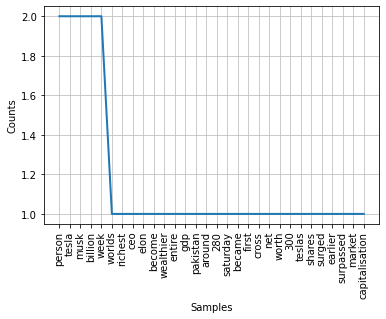

In [11]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30, cumulative=False)
plt.show()

### Lexicon Normalization

In [12]:
# Stemming
from nltk.stem import PorterStemmer

st = PorterStemmer()
news_df['news_article'][:5].apply(lambda x: " "\
                            .join([st.stem(word) for word in x.split()]))

0    world richest person tesla ceo elon musk becom...
1    relianc jio reportedli said wont opt govern fo...
2    indianamerican astronaut raja chari take first...
3    whatsapp longer support android phone run os 4...
4    facebook chang compani name meta mumbai polic ...
Name: news_article, dtype: object

In [13]:
# Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
lem = WordNetLemmatizer()
news_df['news_article'][:5].apply(lambda x: " "\
                            .join([lem.lemmatize(word, "v") \
                                for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    worlds richest person tesla ceo elon musk beco...
1    reliance jio reportedly say wont opt governmen...
2    indianamerican astronaut raja chari take first...
3    whatsapp longer support android phone run os 4...
4    facebook change company name meta mumbai polic...
Name: news_article, dtype: object

In [14]:
news_df['news_article'][:5].apply(lambda x: " "\
                            .join([lem.lemmatize(word, "n") \
                                for word in x.split()]))

0    world richest person tesla ceo elon musk becom...
1    reliance jio reportedly said wont opt governme...
2    indianamerican astronaut raja chari take first...
3    whatsapp longer support android phone running ...
4    facebook changed company name meta mumbai poli...
Name: news_article, dtype: object

In [15]:
# Object Standardization
lookup_dict = {'rt':'Retweet', 'dm':'direct message', \
               'awsm':'awesome', 'luv':'love'}

def _lookup_words(input_text):
    words = input_text.split()
    new_words = []
    for word in words:
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]

        new_words.append(word)
        new_text = " ".join(new_words)

    return new_text

_lookup_words("RT this is a retweeted tweet by Shivam Bansal")

'Retweet this is a retweeted tweet by Shivam Bansal'

## Feature Engineering

In [16]:
# Part of Speech (POS) Tagging
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')
text = "I am learning Text Analytics at IVE(TY)."
tokens = word_tokenize(text)
print(pos_tag(tokens))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[('I', 'PRP'), ('am', 'VBP'), ('learning', 'VBG'), ('Text', 'NNP'), ('Analytics', 'NNP'), ('at', 'IN'), ('IVE', 'NNP'), ('(', '('), ('TY', 'NNP'), (')', ')'), ('.', '.')]


In [17]:
# N-Grams as Features
from textblob import TextBlob

TextBlob(news_df['news_article'][1]).ngrams(3)

[WordList(['reliance', 'jio', 'reportedly']),
 WordList(['jio', 'reportedly', 'said']),
 WordList(['reportedly', 'said', 'wont']),
 WordList(['said', 'wont', 'opt']),
 WordList(['wont', 'opt', 'governments']),
 WordList(['opt', 'governments', 'fouryear']),
 WordList(['governments', 'fouryear', 'moratorium']),
 WordList(['fouryear', 'moratorium', 'spectrum']),
 WordList(['moratorium', 'spectrum', 'adjusted']),
 WordList(['spectrum', 'adjusted', 'gross']),
 WordList(['adjusted', 'gross', 'revenue']),
 WordList(['gross', 'revenue', 'agr']),
 WordList(['revenue', 'agr', 'payments']),
 WordList(['agr', 'payments', 'becoming']),
 WordList(['payments', 'becoming', 'telecom']),
 WordList(['becoming', 'telecom', 'company']),
 WordList(['telecom', 'company', 'earlier']),
 WordList(['company', 'earlier', 'bharti']),
 WordList(['earlier', 'bharti', 'airtel']),
 WordList(['bharti', 'airtel', 'vodafone']),
 WordList(['airtel', 'vodafone', 'idea']),
 WordList(['vodafone', 'idea', 'vi']),
 WordList(['

In [18]:
## Statistical Features
# Term frequency (TF)
tf1 = (news_df['news_article'][1:2]).apply(lambda x: \
                    pd.value_counts(x.split(" ")))\
                    .sum(axis = 0).reset_index()
tf1.columns = ['words', 'tf']
tf1.head()

,words,tf
0,reliance,2
1,jio,2
2,spectrum,2
3,moratorium,2
4,governments,1


In [19]:
# Inverse Document Frequency (IDF)
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(news_df.shape[0]/\
                        (len(news_df[news_df['news_article']\
                        .str.contains(word)])))

tf1.head()

,words,tf,idf
0,reliance,2,4.317488
1,jio,2,4.317488
2,spectrum,2,4.317488
3,moratorium,2,4.317488
4,governments,1,4.317488


In [20]:
# TF-IDF
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1.head()

,words,tf,idf,tfidf
0,reliance,2,4.317488,8.634976
1,jio,2,4.317488,8.634976
2,spectrum,2,4.317488,8.634976
3,moratorium,2,4.317488,8.634976
4,governments,1,4.317488,4.317488


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
            stop_words= 'english', ngram_range=(1,1))

news_vect = tfidf.fit_transform(news_df['news_article'][1:2])
print(news_vect)

  (0, 12)	0.14907119849998599
  (0, 8)	0.14907119849998599
  (0, 7)	0.14907119849998599
  (0, 0)	0.14907119849998599
  (0, 20)	0.14907119849998599
  (0, 29)	0.14907119849998599
  (0, 19)	0.14907119849998599
  (0, 23)	0.14907119849998599
  (0, 10)	0.14907119849998599
  (0, 1)	0.14907119849998599
  (0, 30)	0.14907119849998599
  (0, 15)	0.14907119849998599
  (0, 31)	0.14907119849998599
  (0, 4)	0.14907119849998599
  (0, 5)	0.14907119849998599
  (0, 9)	0.14907119849998599
  (0, 6)	0.14907119849998599
  (0, 28)	0.14907119849998599
  (0, 21)	0.14907119849998599
  (0, 3)	0.14907119849998599
  (0, 25)	0.14907119849998599
  (0, 14)	0.14907119849998599
  (0, 2)	0.14907119849998599
  (0, 27)	0.29814239699997197
  (0, 17)	0.29814239699997197
  (0, 11)	0.14907119849998599
  (0, 13)	0.14907119849998599
  (0, 18)	0.14907119849998599
  (0, 32)	0.14907119849998599
  (0, 26)	0.14907119849998599
  (0, 24)	0.14907119849998599
  (0, 16)	0.29814239699997197
  (0, 22)	0.29814239699997197


## Important Text Analytics Tasks

### 1. Sentiment Analysis

In [22]:
# Sentiment Analysis Using TextBlob
from textblob import TextBlob

news_df['news_article'][:5].apply(lambda x: TextBlob(x).sentiment)

0    (0.09166666666666667, 0.25972222222222224)
1                                  (0.15, 0.45)
2    (0.02777777777777778, 0.16666666666666666)
3    (0.08333333333333333, 0.41666666666666663)
4                                    (0.5, 0.5)
Name: news_article, dtype: object

In [23]:
# Sentiment Analysis Using NLTK
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
 
def word_feats(word):
    return dict([(char, True) for char in word])
 
positive_vocab = [ 'awesome', 'outstanding', 'fantastic', 'terrific', 'good', 'nice', 'great', ':)' ]
negative_vocab = [ 'bad', 'terrible','useless', 'hate', ':(' ]
neutral_vocab = [ 'movie','the','sound','was','is','actors','did','know','words','not' ]
 
positive_features = [(word_feats(pos), 'pos') for pos in positive_vocab]
negative_features = [(word_feats(neg), 'neg') for neg in negative_vocab]
neutral_features = [(word_feats(neu), 'neu') for neu in neutral_vocab]
 
train_set = negative_features + positive_features + neutral_features
 
classifier = NaiveBayesClassifier.train(train_set) 
 
# Predict
neg = 0
pos = 0
sentence = "Awesome movie, I liked it"
sentence = sentence.lower()
words = sentence.split(' ')

for word in words:
    classResult = classifier.classify( word_feats(word))
    if classResult == 'neg':
        neg = neg + 1
    if classResult == 'pos':
        pos = pos + 1
 
print('Positive: ' + str(float(pos)/len(words)))
print('Negative: ' + str(float(neg)/len(words)))

Positive: 0.6
Negative: 0.2


### 2. Text Classification

In [24]:
from textblob.classifiers import NaiveBayesClassifier as NBC
from textblob import TextBlob

training_corpus = [
    ('I am exhausted of this work.', 'Class_B'),
    ("I can't cooperate with this", 'Class_B'),
    ('He is my badest enemy!', 'Class_B'),
    ('My management is poor.', 'Class_B'),
    ('I love this burger.', 'Class_A'),
    ('This is an brilliant place!', 'Class_A'),
    ('I feel very good about these dates.', 'Class_A'),
    ('This is my best work.', 'Class_A'),
    ("What an awesome view", 'Class_A'),
    ('I do not like this dish', 'Class_B')]

test_corpus = [
    ("I am not feeling well today.", 'Class_B'),
    ("I feel brilliant!", 'Class_A'),
    ('Gary is a friend of mine.', 'Class_A'),
    ("I can't believe I'm doing this.", 'Class_B'),
    ('The date was good.', 'Class_A'), ('I do not enjoy my job', 'Class_B')]

model = NBC(training_corpus)
print(model.classify("Their codes are amazing."))

Class_A


In [25]:
print(model.classify("I don't like their computer."))

Class_B


In [26]:
print(model.accuracy(test_corpus))

0.8333333333333334


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import svm

# Preparing data for SVM model (using the same training_corpus, test_corpus
#   from naive bayes example)
train_data = []
train_labels = []
for row in training_corpus:
    train_data.append(row[0])
    train_labels.append(row[1])

test_data = []
test_labels = []
for row in test_corpus:
    test_data.append(row[0])
    test_labels.append(row[1])

# Create feature vectors
vectorizer = TfidfVectorizer(min_df=4, max_df=0.9)

# Train the feature vectors
train_vectors = vectorizer.fit_transform(train_data)

# Apply model on test data
test_vectors = vectorizer.transform(test_data)

# Perform classification with SVM, kernel=linear
model = svm.SVC(kernel='linear')
model.fit(train_vectors, train_labels)
prediction = model.predict(test_vectors)
print(prediction)
# print(classification_report(test_labels, prediction))

['Class_A' 'Class_A' 'Class_B' 'Class_B' 'Class_A' 'Class_A']


### 3. Chatbot